In [64]:
import torch
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import krevera_synthetic_dataset
import json
from tqdm import tqdm
import torch.nn as nn

import importlib
importlib.reload(krevera_synthetic_dataset)
from krevera_synthetic_dataset import KreveraSyntheticDataset
from torchvision import models
import torch.nn.functional as F

In [2]:
#### Extract test and train zip files #####

# zip_file_path_test = 'krevera_synthetic_dataset_test.zip'
# destination_directory_test = './'

# with zipfile.ZipFile(zip_file_path_test, 'r') as zip_ref:
#     zip_ref.extractall(destination_directory_test)

# print(f"Extracted all files to {destination_directory_test}")

# zip_file_path_train = 'krevera_synthetic_dataset_train.zip'
# destination_directory_train = './'

# with zipfile.ZipFile(zip_file_path_train, 'r') as zip_ref:
#     zip_ref.extractall(destination_directory_train)

# print(f"Extracted all files to {destination_directory_train}")



Extracted all files to ./
Extracted all files to ./


In [ ]:
##TESTING STUFF

# dataset = KreveraSyntheticDataset("./krevera_synthetic_dataset_test", zero_one_normalize=True)

# print(f"Dataset length: {len(dataset)}")

# datapoint = dataset[45]

# num_images, num_channels, height, width = datapoint["input_rgb"].shape
# print(datapoint["input_rgb"].shape)

# print(datapoint.keys())

# from tqdm import tqdm
# areas_flash = []
# heights_flash = []
# lengths_flash = []

# data_loader = torch.utils.data.DataLoader(
#         dataset,
#         batch_size=1,
#         shuffle=True,
#         num_workers=1,
#         pin_memory=True,
#         drop_last=True,
#         multiprocessing_context="spawn",
#     )

# i = 1
# for batch in data_loader:
#     print(batch["target_flash_max_average_height"])


In [ ]:
# '''Understand Data distribution of flask areas''' 

# def save_flash_data(dataset, dataset_type="test"):

#     ### Loop through dataset to and extract flash area data. Save into txt file for easy loading later
#     ### we don't just loop over the batches because this will load images as well which takes a long time. 

#     ## Test Dataset
#     flash_avg_heights = []
#     flash_max_lengths = []
#     flash_total_areas = []

#     for i in tqdm(range(len(dataset))):
#         datapoint_path = dataset.datapoint_paths[i]

#         #### Bounding bocx List stuff #########################################################
#         bounding_box_2d_tight_list = []
#         bounding_box_2d_tight_prim_paths_list = []
#         for render_product_name in dataset.render_product_names:
#             render_product_path = os.path.join(datapoint_path, render_product_name)

#             bounding_box_2d_tight_list.append(
#                     np.load(
#                         dataset.file_system.open(
#                             os.path.join(render_product_path, "bounding_box_2d_tight.npy"),
#                             "rb",
#                         )
#                     )
#                 )
            
#             bounding_box_2d_tight_prim_paths_list.append(
#                     json.load(
#                         dataset.file_system.open(
#                             os.path.join(
#                                 render_product_path,
#                                 "bounding_box_2d_tight_prim_paths.json",
#                             )
#                         )
#                     )
#                 )
#         ######################################################################################

#         flash_defects = json.load(
#                 dataset.file_system.open(
#                     os.path.join(
#                         datapoint_path, dataset.scene_product_name, "flash_defects.json"
#                     )
#                 )
#             )
        
#         (
#             flash_defects_max_average_height,
#             flash_defects_max_length,
#             flash_defects_total_area,
#         ) = dataset._compute_global_flash_defects(
#             flash_defects,
#             bounding_box_2d_tight_list,
#             bounding_box_2d_tight_prim_paths_list,
#         )

#         flash_avg_heights.append(flash_defects_max_average_height.item())
#         flash_max_lengths.append(flash_defects_max_length.item())
#         flash_total_areas.append(flash_defects_total_area.item())

    
#     np.save(f"{dataset_type}_flash_avg_heights", flash_avg_heights)
#     np.save(f"{dataset_type}_flash_max_lengths", flash_max_lengths)
#     np.save(f"{dataset_type}_flash_total_areas", flash_total_areas)





percent of flash area in bin 0:
1625
29.88%


/home/exouser/miniconda3/envs/krevera_env/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6898: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


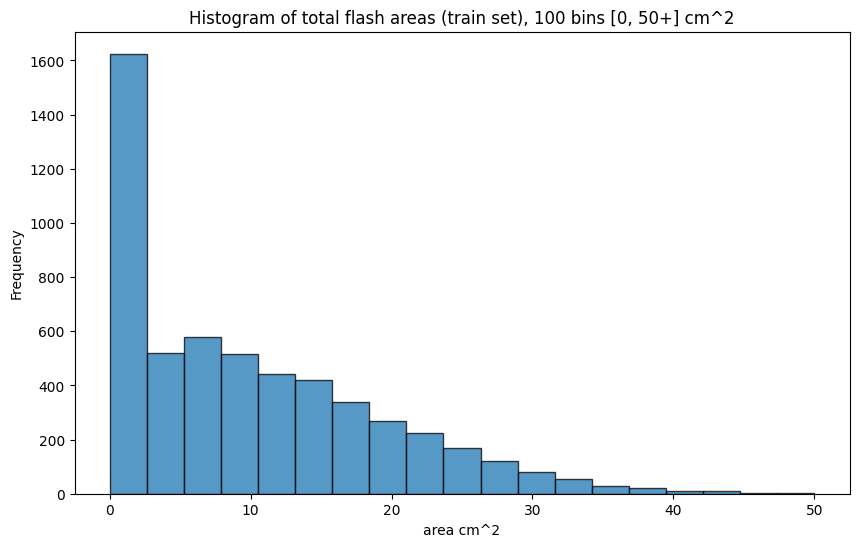

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), array([1625,  520,  578,  516,  442,  420,  339,  270,  224,  170,  121,
         80,   55,   27,   22,   11,   11,    3,    2,    3]))


In [88]:
# hist, bins = np.histogram(flash_total_areas, bins=bin_edges)
### Now lets analyze the flash data

train_dataset = KreveraSyntheticDataset("./krevera_synthetic_dataset_train", zero_one_normalize=True, is_train=True, num_bins=20)
dataset_type = "train"
bin_edges = np.linspace(0, 50, 20)
bin_edges = np.append(bin_edges, np.inf)

flash_avg_heights = np.load(f"{dataset_type}_flash_data/{dataset_type}_flash_avg_heights.npy")*100
flash_max_lengths = np.load(f"{dataset_type}_flash_data/{dataset_type}_flash_max_lengths.npy")*100
flash_total_areas = np.load(f"{dataset_type}_flash_data/{dataset_type}_flash_total_areas.npy")*100*100

# print(max(flash_total_areas))
bin_classes = np.digitize(flash_total_areas, bin_edges, right=False) - 1
print(f"percent of flash area in bin {0}:")
print(np.sum(bin_classes == 0))
print(f"{round(np.sum(bin_classes == 0) / len(bin_classes)*100, 2)}%")

plt.figure(figsize=(10, 6))
plt.hist(flash_total_areas, bins=bin_edges, edgecolor='black', alpha=0.75)
plt.title('Histogram of total flash areas (train set), 100 bins [0, 50+] cm^2')
plt.xlabel('area cm^2')
plt.ylabel('Frequency')
plt.show()

print(np.unique(bin_classes, return_counts=True))


In [97]:
class_counts = np.bincount(bin_classes, minlength=20)
inverse_frequencies = 1 / np.where(class_counts == 0, np.inf, class_counts)
print(inverse_frequencies)
inverse_frequencies[-6:] = 0.04545455
alphas = inverse_frequencies / np.sum(inverse_frequencies)
smoothing_factor = 0.1  # This factor can be tuned
alphas = (alphas * (1 - smoothing_factor)) + (smoothing_factor / len(class_counts))

print("Alpha values:", alphas)
# save alphas
np.save("alphas.npy", alphas)

[0.00061538 0.00192308 0.0017301  0.00193798 0.00226244 0.00238095
 0.00294985 0.0037037  0.00446429 0.00588235 0.00826446 0.0125
 0.01818182 0.03703704 0.04545455 0.09090909 0.09090909 0.33333333
 0.5        0.33333333]
Alpha values: [0.0064708  0.00959625 0.00913504 0.00963188 0.01040736 0.0106906
 0.0120503  0.01385205 0.01566988 0.01905913 0.0247525  0.03487566
 0.0484555  0.09352046 0.11363876 0.11363876 0.11363876 0.11363876
 0.11363876 0.11363876]


In [53]:
# class weights for loss function

classes = np.array(range(100))
class_weights = np.zeros(100)

N = len(bin_classes)
n = 100

for i in range(100):
    class_weights[i] = N / (n*np.sum(bin_classes == i))
    

min_weight = np.min(class_weights)
class_weights[class_weights == np.inf] = min_weight
class_weights = class_weights / np.sum(class_weights)
print(np.max(class_weights))

# save class weights
np.save("100_class_weights", class_weights.astype(np.float32))

# load class weights
class_weights = np.load("100_class_weights.npy")
print(class_weights.shape)
class_weights = torch.tensor(class_weights).to("cuda")
print(class_weights.shape)


NameError: name 'bin_classes' is not defined

1e-06 0.001


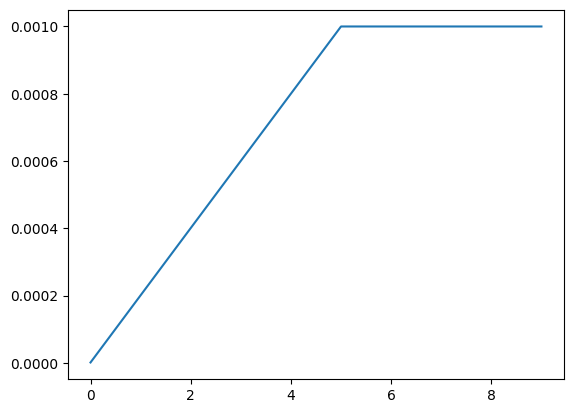

In [49]:
lr = 1e-3
warmup_epochs = 5
def lambda1(current_epoch):
    if current_epoch < warmup_epochs:
        return 0.001 + (1.0 - 0.001) * (current_epoch / warmup_epochs)
    return 1.0
lrs = []
for i in range(100):
    lrs.append(lambda1(i)*lr)
lrs = np.array(lrs)
print(np.min(lrs), np.max(lrs))

plt.plot(range(10), lrs[:10])





In [65]:
# Load in datasets

test_dataset = KreveraSyntheticDataset("./krevera_synthetic_dataset_test", zero_one_normalize=True, is_train=False)
train_dataset = KreveraSyntheticDataset("./krevera_synthetic_dataset_train", zero_one_normalize=True, is_train=True)

# create small dataset of size 1
# this will be used to test training loop
# notice there are no transforms applied to this dataset
dummy_dataset = torch.utils.data.Subset(test_dataset, [0, 1])
print(len(train_dataset))


5439


In [ ]:
# normalize data. 

def compute_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=7, num_workers=32, shuffle=False)
    
    mean = 0.0
    std = 0.0
    total_images_count = 0
    i = 0
    for batch in loader:
        print(i)
        batch = batch["input_rgb"]
        # print(batch.shape)
        batch = batch.view(batch.shape[0]*batch.shape[1], batch.shape[2], -1)
        # print(batch.shape)
        mean += batch.mean(2).sum(0)
        std += batch.std(2).sum(0)
        total_images_count += batch.shape[0]
        i+=1 
    
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

mean, std = compute_mean_std(train_dataset)
print(mean, std)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5782)
tensor(11.6741)
tensor(13.2897)
tensor(26)
torch.Size([5, 3, 544, 960])
torch.Size([5, 544, 960])
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
torch.Size([3, 544, 960])


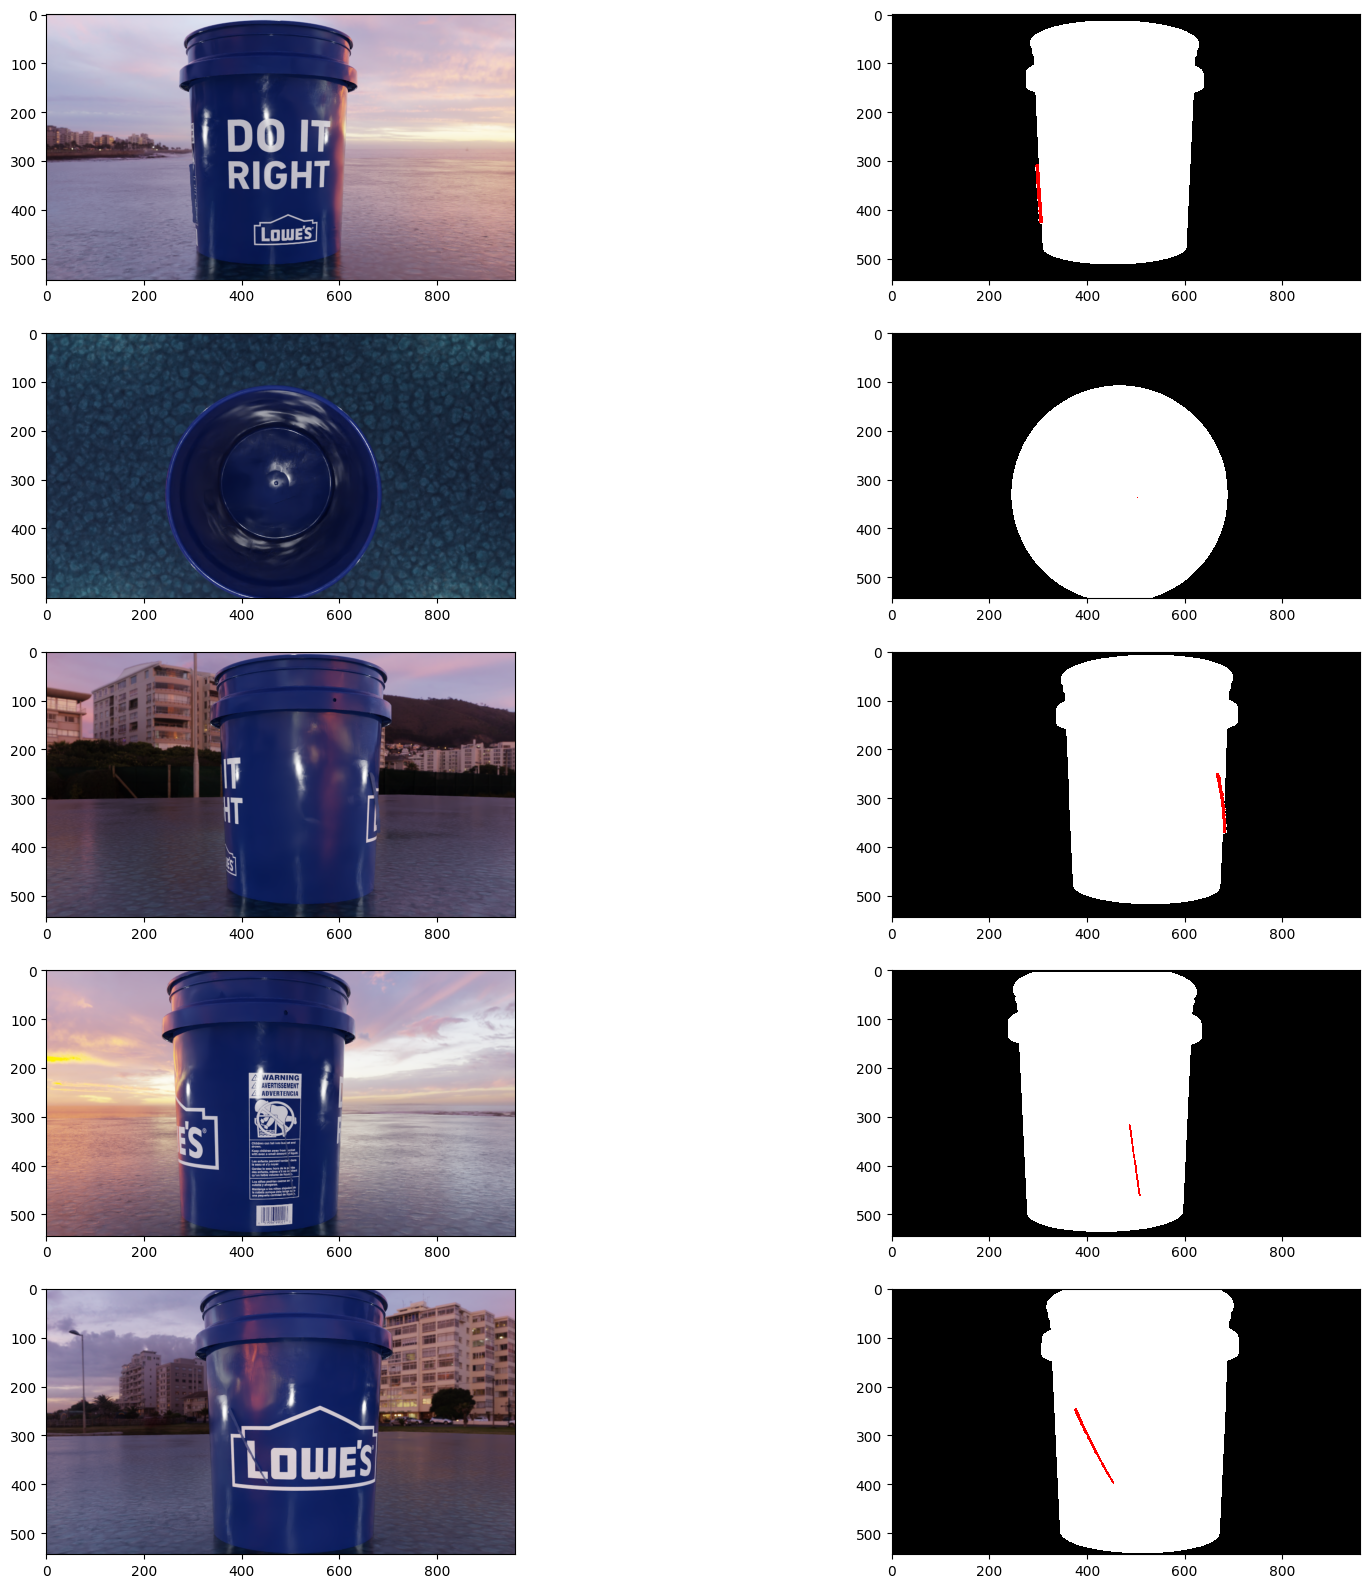

In [79]:
# visualize data
datapoint = test_dataset[87]

# fig, axs = plt.subplots(2, 5, figsize=(15, 6))
mean=np.array([0.4016, 0.3994, 0.4520])
std=np.array([0.2425, 0.2206, 0.1979])
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
colors = ['black', 'white', 'red']
cmap = ListedColormap(colors)
print(datapoint["target_flash_max_average_height"]*100)
print(datapoint["target_flash_max_length"]*100)
print(datapoint["target_flash_total_area"]*100*100)
print(datapoint["bin_num"])
print(datapoint['target_segmentation'].shape)
datapoint['target_segmentation_plot'] = torch.argmax(datapoint['target_segmentation'], dim=1)
print(datapoint['target_segmentation_plot'].shape)
for i in range(5):
    axs[i, 0].imshow(datapoint["input_rgb"][i, :, :, :].permute(1, 2, 0).numpy()*std + mean)
    axs[i, 1].imshow(datapoint["target_segmentation_plot"][i, :, :].numpy(), cmap=cmap, vmin=0, vmax=2)
    print(np.unique(datapoint["target_segmentation_plot"][i, :, :].numpy()))
    
print(datapoint["input_rgb"][0, :, :, :].shape)
# gt_seg = F.one_hot(datapoint["target_segmentation"][0, :, :], num_classes=3).permute(2, 0, 1)
# print(datapoint["target_segmentation"][0, :, :].numpy().shape)
# print(gt_seg.shape)
plt.show()

torch.Size([1, 2048, 32, 32])
torch.Size([2, 100])


In [34]:
### Multi-View CNN (MVCNN) Architecture ###

class MVCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(MVCNN, self).__init__()
        self.num_classes = num_classes
        resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        fc_in_features = resnet50.fc.in_features
        self.feature_extractor = nn.Sequential(*list(resnet50.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1)) # As in ResNet
        self.classifier = nn.Linear(fc_in_features, num_classes)
        

    def forward(self, inputs):
        num_views = inputs.size(1)
        batch_size = inputs.size(0)
        x = inputs.view(-1, inputs.size(2), inputs.size(3), inputs.size(4))
        x = self.feature_extractor(x)
        x = x.view(batch_size, num_views, x.shape[-3], x.shape[-2], x.shape[-1])
        x = torch.max(x, 1)[0]
        x = self.adaptive_pool(x)
        x = self.classifier(x.squeeze())
        return x





In [35]:
from tqdm import tqdm
model = MVCNN(num_classes=100)

# Load model weights

model.load_state_dict(torch.load("best_model.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate model on test set
available_cores = os.cpu_count()
batch_size = 12
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=available_cores)

model.to(device)
correct = 0
prediction_tracker = []
targets_tracker = []
model.eval()

with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):
        inputs = batch["input_rgb"].to(device)
        targets = batch["bin_num"].to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        correct += torch.sum(predictions == targets).item()
        prediction_tracker.extend(predictions.cpu().numpy())
        targets_tracker.extend(targets.cpu().numpy())
    
accuracy = correct / len(test_dataset)
print(f"Accuracy on test set: {accuracy}")


0it [00:00, ?it/s]/home/exouser/miniconda3/envs/krevera_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
8it [00:17,  2.14s/it]


Accuracy on test set: 0.21212121212121213


In [ ]:
# Create confusion matrix
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns 

# y_true = np.array(targets_tracker)
# y_pred = np.array(prediction_tracker)

# # Compute confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Visualizing the confusion matrix using matplotlib and seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix')
# plt.show()


Epoch 1


OutOfMemoryError: CUDA out of memory. Tried to allocate 132.00 MiB (GPU 0; 40.00 GiB total capacity; 36.18 GiB already allocated; 68.50 MiB free; 36.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

In [8]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to("cuda")


feature_extractor = nn.Sequential(*list(resnet50.children())[:-1])
linear1 = nn.Linear(5*2048, 1024).to("cuda")
linear2 = nn.Linear(1024, 100).to("cuda")
dummy_image = torch.randn(5*8, 3, 1024, 1024).to("cuda")
with torch.no_grad():
    x = feature_extractor(dummy_image)
    x = x.view(8, 5, 2048, 1, 1)
    x = x.view(8, 5*2048, 1, 1)
    x = linear1(x.squeeze())
    x = linear2(x)

print(x.shape)
print()

# # purposefule error stop ########
# x = torch.rand(1, 3, 1024, 1024)
# x.view((4, 4))
# ##################################
# dummy_vec = torch.randn(2, 2048, 1, 1)
# linear = nn.Linear(2048, 100)
# output = linear(dummy_vec.squeeze())
# print(output.shape)

torch.Size([8, 100])



In [23]:
save_flash_data(train_dataset, dataset_type="train")

100%|██████████| 5439/5439 [00:05<00:00, 1026.49it/s]


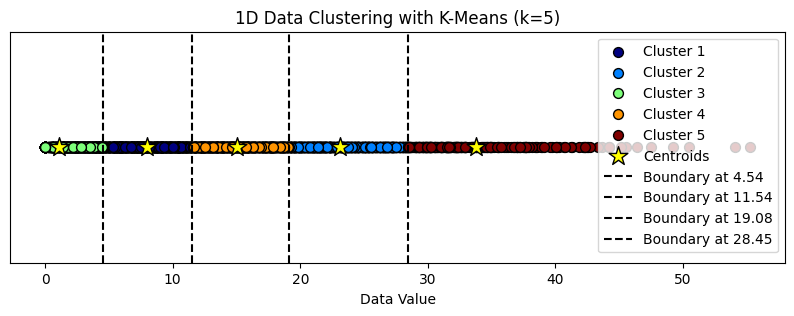

In [61]:
##### Let's use k-means to split the data into clusters. We can think about the clusters as classes. 
from sklearn.cluster import KMeans

num_classes = 5 # analagous to number of clusters
data = flash_total_areas.reshape(-1, 1)
kmeans = KMeans(n_clusters=num_classes, n_init=100, random_state=0).fit(data)

centroids = kmeans.cluster_centers_

# Since we are looking at 1d data we can easily get the decision boundaries.
# Sort the centroids to ensure correct boundary calculations
sorted_centroids = np.sort(centroids.reshape(-1))
# Calculate the midpoints between adjacent centroids to get the decision boundaries
decision_boundaries = (sorted_centroids[:-1] + sorted_centroids[1:]) / 2.0
labels = kmeans.labels_

# Visualization
plt.figure(figsize=(10, 3))

# Generate distinct colors for each cluster
colors = plt.cm.jet(np.linspace(0, 1, num_classes))

# Plot the data points and color them based on their cluster label
for i in range(num_classes):
    plt.scatter(data[labels == i], np.zeros_like(data[labels == i]), color=colors[i], label=f'Cluster {i+1}', edgecolors='black', s=50)

# Plot the centroids
plt.scatter(centroids, np.zeros_like(centroids), color='yellow', s=200, marker='*', edgecolors='black', label='Centroids')

# Plot the decision boundaries
for boundary in decision_boundaries:
    plt.axvline(x=boundary, color='black', linestyle='--', label=f'Boundary at {boundary:.2f}')

plt.title(f'1D Data Clustering with K-Means (k={num_classes})')
plt.yticks([])  # Remove y-axis as it's not needed for 1D representation
plt.xlabel('Data Value')
plt.legend()
plt.show()

In [14]:
# ### Test to make sure values are equivalent to dataset class getitem method
# ### Use multiprocessing to speed up 
# import multiprocessing


# def test_datapoint_flash_matches(i):
#     datapoint = test_dataset[i]
#     assert datapoint["target_flash_max_average_height"].item() == flash_avg_heights[i], f"Mismatch at {i} for height"
#     assert datapoint["target_flash_max_length"].item() == flash_max_lengths[i], f"Mismatch at {i} for length"
#     assert datapoint["target_flash_total_area"].item() == flash_total_areas[i], f"Mismatch at {i} for area"
#     print(i, end=" ")

# num_processes = multiprocessing.cpu_count()
# print(num_processes)
# with multiprocessing.Pool(processes=num_processes) as pool:
#     pool.map(test_datapoint_flash_matches, range(len(test_dataset)))


32
17 13 29 15 25 14 9 10 1 8 2 5 23 30 0 27 22 4 21 7 24 28 6 20 3 11 19 4137  18 31 35 1626  12 38 47 39 48 45 50 33 4460  42 49 36 57 43 54 61 40 34 58 53 46 66 51 65 64 52 6732  56 59 77 55 80 69 62 78 71 87 68 81 63 76 70 82 79 72 74 85 84 90 89 88 86 83 73 75 95 98 92 91 93 96 97 94 

[0 1 2]
tensor(0.0066)
tensor(0.1330)
tensor(0.0009)
[0 1]
tensor(0.0066)
tensor(0.1330)
tensor(0.0009)


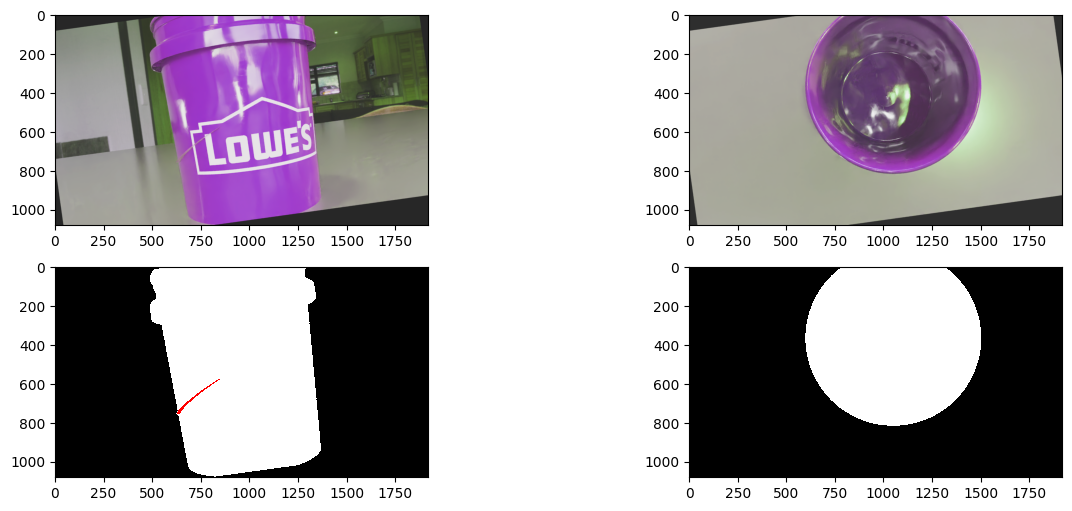

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
colors = ['black', 'white', 'red']
cmap = ListedColormap(colors)
for i in range(2):
    axs[0, i].imshow(datapoint["input_rgb"][i, :, :, :].permute(1, 2, 0).numpy())
    axs[1, i].imshow(datapoint["target_segmentation"][i, :, :].numpy(), cmap=cmap, vmin=0, vmax=2)
    print(np.unique(datapoint["target_segmentation"][i, :, :].numpy()))
    print(datapoint["target_flash_max_average_height"])
    print(datapoint["target_flash_max_length"])
    print(datapoint["target_flash_total_area"])

plt.show()

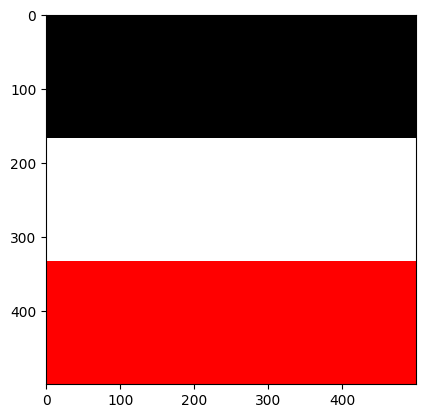

In [32]:
array = np.zeros((500, 500))

array[167:334, :] = 1  
array[334:, :] = 2

plt.imshow(array, cmap=cmap)

In [8]:
bin_edges = np.linspace(0, 50, 100) # defined by Edward. 
bin_edges = np.append(bin_edges, np.inf)

def get_class_num(x):
    return np.digitize(x, bin_edges, right=False) - 1
     


array([ 0.        ,  0.50505051,  1.01010101,  1.51515152,  2.02020202,
        2.52525253,  3.03030303,  3.53535354,  4.04040404,  4.54545455,
        5.05050505,  5.55555556,  6.06060606,  6.56565657,  7.07070707,
        7.57575758,  8.08080808,  8.58585859,  9.09090909,  9.5959596 ,
       10.1010101 , 10.60606061, 11.11111111, 11.61616162, 12.12121212,
       12.62626263, 13.13131313, 13.63636364, 14.14141414, 14.64646465,
       15.15151515, 15.65656566, 16.16161616, 16.66666667, 17.17171717,
       17.67676768, 18.18181818, 18.68686869, 19.19191919, 19.6969697 ,
       20.2020202 , 20.70707071, 21.21212121, 21.71717172, 22.22222222,
       22.72727273, 23.23232323, 23.73737374, 24.24242424, 24.74747475,
       25.25252525, 25.75757576, 26.26262626, 26.76767677, 27.27272727,
       27.77777778, 28.28282828, 28.78787879, 29.29292929, 29.7979798 ,
       30.3030303 , 30.80808081, 31.31313131, 31.81818182, 32.32323232,
       32.82828283, 33.33333333, 33.83838384, 34.34343434, 34.84

ImportError: cannot import name 'config' from 'config' (/home/exouser/miniconda3/envs/krevera_env/lib/python3.10/site-packages/config/__init__.py)

In [37]:
# use Hrnet
import sys
import os
import hrnet
# Add the hrnet directory to the Python path
hrnet_path = os.path.join(os.getcwd(), 'hrnet')
sys.path.insert(0, hrnet_path)
import importlib
importlib.reload(hrnet)
from hrnet.lib.config import config
from hrnet.lib.models import seg_hrnet
import torch.nn.functional as F

# config file
config_file_path = "hrnet/experiments/cityscapes/seg_hrnet_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484_paddle.yaml"
config.defrost()
config.merge_from_file(config_file_path)
config.freeze()

 # config file load in

hrnet_model = seg_hrnet.get_seg_model(config)



In [46]:
# dummy image into hrnet model

dummy_image = torch.randn(1, 3, 512, 910)
import torch.nn as nn
    
output = hrnet_model(dummy_image)

# output = F.interpolate(output, (512, 910), mode='bilinear')
print(output.shape)

torch.Size([1, 19, 128, 228])


# UNET++


In [3]:
class VGGBlock(nn.Module):
    
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.SE = Squeeze_Excite(out_channels,8)
    
    def forward(self,x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.SE(out)
        
        return(out)
class Squeeze_Excite(nn.Module):
    
    def __init__(self,channel,reduction):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        b, c, _, _ = x.size()
        y = self.avgpool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class NestedUNet(nn.Module):
    
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        
    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

In [4]:
# clear cuda cache
torch.cuda.empty_cache()
model = NestedUNet(num_classes=3, input_channels=3, deep_supervision=True)
model.eval()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (SE): Squeeze_Excite(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=32, bias=False)
        (3): Sigmoid()
      )
    )
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(6

In [5]:
# dummy image
with torch.no_grad():
    dummy_image = torch.randn(8, 3, 1024, 1024)
    output = model(dummy_image)
    print(len(output))


4


torch.Size([8, 3, 1024, 1024])

In [ ]:
# testing loss
import torch
import torch.nn as nn

class WeightedDiceLoss(nn.Module):
    def __init__(self, weights=None, smooth=1e-5):
        super(WeightedDiceLoss, self).__init__()
        self.smooth = smooth
        self.weights = weights  # Expected to be a tensor of shape [C], where C is the number of classes

    def forward(self, inputs, targets):
        # Assuming inputs are raw logits and targets are indices of the ground truth classes
        inputs = torch.softmax(inputs, dim=1)
        
        # Create one-hot encoded targets
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        # Calculate per-class Dice coefficient
        intersection = torch.sum(inputs * targets_one_hot, dim=(2, 3))
        cardinality = torch.sum(inputs + targets_one_hot, dim=(2, 3))
        dice_loss = 1 - (2. * intersection + self.smooth) / (cardinality + self.smooth)
        
        # Apply weights
        if self.weights is not None:
            dice_loss = dice_loss * self.weights.to(dice_loss.device)

        # Instead of mean, you can now do a weighted sum based on the weights provided
        total_loss = dice_loss.sum() / self.weights.sum()
        return total_loss

# Create a dummy model output and target
dummy_output = torch.randn(8, 3, 544, 960)
dummy_target = torch.randn(8, 3, 544, 960)

